In [107]:
%matplotlib widget
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import numpy as np
import os

# from tqdm import tqdm, tqdm_notebook
import math

# from  scipy.special import digamma as ψ
# from mpmath import besseli as Iν
# from scipy.constants import hbar, pi, h, e, k

# kB = k
# γ = 0.57721566
# RQ = h/4/e**2
# Φ0 = h/2/e

from JJformulas import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notes on theory of JJ

The intention of this note is to summarize and organize the knowledge on the physics of single JJ, namely TA and Q phase diffusion, environment impedance influence, Bloch oscillations, etc  

## 1. RS(C)J-model

The simplest model considers current-biasing circuit consisted of Josephson element, Resistor and capasitor.

$I_s = I_c \sin \phi$

$\dot{\phi} = \frac{2 e}{ \hbar} V $

$ I_0 = \frac{\hbar C}{2e} \ddot{ \phi }  + \frac{\hbar}{ 2eR} \dot \phi + I_c \sin \phi $


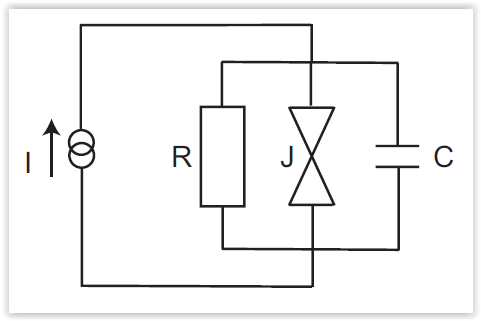
[Kopnin lecture]

$\omega_p = \sqrt{2eI_c/\hbar C} = \sqrt{8 E_J E_C}$ - plasma frequency

$Q = \omega_p R C$ - quality factor

### 1a) $C \rightarrow \infty $
Equvalent to underdamped regime ( $ 1/ \omega_p C \ll R $, $Q \gg 1$ ). Capacitence completely shunts josephson generation 

$$I_0 < I_c \Rightarrow I_s = I_0, I_R = 0, I_C = 0$$

$$I_0 > I_c \Rightarrow \overline{I_s + I_C} = 0, I_R = I_0$$

### 2a) $ C = 0$

Equvalent to overdamped regime ( $ 1/ \omega_p C \gg R $, $Q \ll 1$ )

For $I_0 > I_c$ Josephson current flows through resistor, so instantaneous voltage changes with time 

In [ ]:
t = np.linsapce(0, 5*2*np.pi, 101)
Vinst = 

$ <I_s> = I_0 - <V>/R = I_0\left(1 - \sqrt{1 - \left( \frac{I_C}{I_0} \right)^2}\right)$

<IPython.core.display.Javascript object>


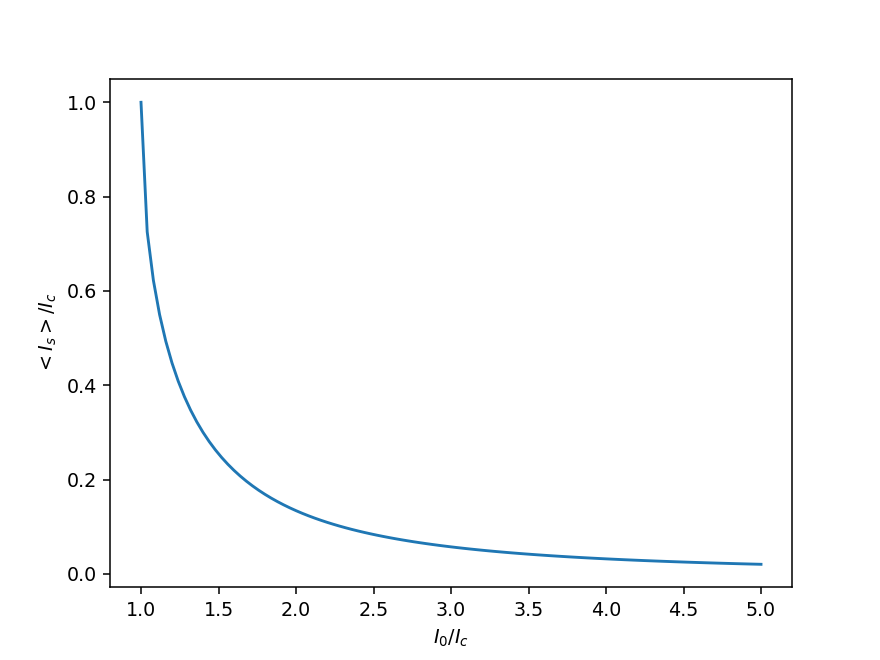

Text(0,0.5,'${<I_s>}/{I_c}$')

In [15]:
i = np.linspace(1, 5, 101)
Is = 1 - np.sqrt(1 - (1/i)**2)

plt.plot(i, Is)
plt.xlabel('${I_0}/{I_c}$')
plt.ylabel('${<I_s>}/{I_c}$')

## 2. Phase diffusion as Fokker-Plank process
[Zil'berman Ivanchenko JEPhT 24 6 1969](http://www.jetp.ac.ru/cgi-bin/dn/e_028_06_1272.pdf )



Note, that I-biased scheme with R||JJ is equvalent to V-biased with R and JJ in series

$ V_B = IR + \dot{ \phi } $  

$ \frac{V_B - IR}{R} =  \frac{\hbar C}{2e} \ddot{ \phi }  + I_c \sin \phi $

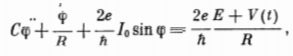

- underdamped limit $C \rightarrow 0$
- volage biasing scheme is equivalent to curernt-biasing with R as a shunt
- note the difference between $I-V_b$ and $I-V$ curves 

$$<I_s> = I_0 \Im \left( \frac{I_{1-2i\beta e V_B/ \hbar R_B}(\beta E_J)}{I_{-2i\beta e V_B/ \hbar R_B}(\beta E_J)} \right)$$

In [75]:
fig, ax = plt.subplots()

Vs = np.linspace(0, 0.4e-3, 501)

R_list = [1e3, 10e3, 50e3]

for R in R_list:
    Is = I_IZ( Vs, EJ = 1, R = R, T = .05)

# ax.plot(  Vs/1e-3, Is/1e-9, '--', label = r'$I-V_b$')
    ax.plot( (Vs - Is*R) /1e-3, Is/1e-9, label = r'$I-V$')
ax.set_xlabel(r'$V, mV$')
ax.set_ylabel(r'$I, nA$')

ax.legend()


FigureCanvasNbAgg()

## 3. Phase diffusion as Fokker-Plank process -2
[Ambegaokar-Halperin PRL 22 25 1969](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.22.1364 )



- The same Fokker-Planck eq with non-zero $C$, overdamped limit $\eta = 1/RC \gg 1$
- Attempt frequency is $\omega_J^2 / 2 \pi \eta =  \omega_J / \beta_C$
- Derived for I-biased regime
- Note the difference between the total current through R||JJ and pure supercurrent

In [72]:
fig, ax = plt.subplots()

Ic = 35e-9

Is = np.linspace(0, 1.5*Ic, 501)

R = 1e3

Vs = V_AH( Is, Ic = Ic, T = 0.05, EJ = 1, Rn = R)

ax.plot(  Vs/1e-3, Is/1e-9, label = r'$I_b - V$')

ax.plot(  Vs/1e-3, (Is - Vs/R)/1e-9, label = r'$I_s - V$')


ax.set_xlabel(r'$V, mV$')
ax.set_ylabel(r'$I, nA$')



ax.legend()


FigureCanvasNbAgg()

## 4. Phase diffusion as activation process 
Kautz Martinis

### 4a. Thermally activated PD

# Coulomb at P(E)

## $E_J$ renormalization

In the limit $E_J \ll E_C$ and high-resistive environment a probability of CP tunneling is quadratic in $E_J$ and effective $E_J$ can be calculated ([Mesoscopic Josephson Effect Superlatt. Microstruct. 25, 915 (1999)](https://www.physik.uni-augsburg.de/theo1/ingold/publikationen_coll/grabe99/grabe99.pdf) )


In [63]:
Renv_list = np.logspace(2, 6, 101)

RN = 10e3


Cj_list = [1e-15, 1.5e-15, 2e-15]
fig, ax1 = plt.subplots()

for Cj in Cj_list:
    EJs = EJ_star (EJ = EJ_AB(RN), R = Renv_list, T = .03, C = Cj)

    ax1.plot( Renv_list , EJs, label = r'C = {:1.2f} fF'.format(Cj/1e-15 ))

# ax1.plot( Renv_list , EJ_AB(RN), '--k', alpha = 0.5)
ax1.axhline(EJ_AB(RN), 0 , 1, ls = '--', color = 'k', alpha = 0.5)


ax1.legend()

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$R_{env}, K$')
ax1.set_ylabel(r'$E_J^*, K$')

D:\anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


FigureCanvasNbAgg()

Text(0, 0.5, '$E_J^*, K$')

### T-dependence

In [76]:
Renv_list = np.logspace(2, 6, 101)

RN = 10e3

Cj = 1.5e-15

Tb_list = [0.05, 0.10, .15]
fig, ax1 = plt.subplots()

for Tb in Tb_list:
    EJs = EJ_star (EJ = EJ_AB(RN), R = Renv_list, T = Tb, C = Cj)

    ax1.plot( Renv_list , EJs, label = r'T = {:3.0f} mK'.format(Tb/1e-3 ))

# ax1.plot( Renv_list , EJ_AB(RN), '--k', alpha = 0.5)
ax1.axhline(EJ_AB(RN), 0 , 1, ls = '--', color = 'k', alpha = 0.5)


ax1.legend()

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$R_{env}, K$')
ax1.set_ylabel(r'$E_J^*, K$')

FigureCanvasNbAgg()

Text(0, 0.5, '$E_J^*, K$')

## $R_0$ as a result of thermal diffusion + $E_J$ renormalization

In [58]:
R_list = np.logspace(2, 5.5, 51)

Cj = 1.75e-15
Tb = 0.035

EJs = EJ_star (EJ = EJ_AB(R_list), R = R_list, T = Tb, C = Cj)

fig, ax1 = plt.subplots()

R0s = []

for R in R_list:
    R0 = find_R0( R, T = Tb, C = Cj)
    R0s.append(R0)

ax1.plot( EJ_AB(R_list) , R0s, label = r'C = {:1.2f} fF'.format(Cj/1e-15))




ax1.legend()

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$E_J, K$')
ax1.set_ylabel(r'$R_0, k \Omega$')

FigureCanvasNbAgg()

Text(0, 0.5, '$R_0, k \\Omega$')

### T-dependence

In [82]:
RN = 10e3
R_env = 100e3

Cj = 2e-15
Tb_list =  np.linspace(0.05, .25, 51)

# EJs = EJ_star (EJ = EJ_AB(RN), R = R_env, T = Tb, C = Cj)

fig, ax1 = plt.subplots()

R0s = []

for Tb in Tb_list:
    R0 = find_R0( RN, R_env = R_env , T = Tb, C = Cj)
    R0s.append(R0)

ax1.plot( Tb_list , R0s, label = r'C = {:1.2f} fF'.format(Cj/1e-15))




ax1.legend()

# ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$T, K$')
ax1.set_ylabel(r'$R, k \Omega$')

FigureCanvasNbAgg()

Text(0, 0.5, '$R, k \\Omega$')

In [128]:
fig, ax = plt.subplots()
T = np.linspace(0.05, 0.85, 101)

# ax.plot( T , Rj(1e3, T))
ax.plot( T , 1 / ( 1e-9 +  1e-6*np.exp(  -2/T )) )  
ax.set_yscale('log')

FigureCanvasNbAgg()

In [106]:
np.exp(-100)

3.720075976020836e-44